In [1]:
#Basic pre-reqs:
import numpy as np
import torch
import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from celluloid import Camera
from copy import deepcopy as copy
%matplotlib inline

#!pip install celluloid

#!export CUDA=cu101 && pip install --upgrade torch-scatter==latest+${CUDA} torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.7.0.html
#!pip install --upgrade torch-geometric

# Mount your google drive in google colab
#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/ColabNotebooks/MLAM/GN_ABPs'

import models
import simulate

In [2]:
from sklearn.model_selection import train_test_split

import networkx as nx
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.utils import to_networkx

from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

from torch_geometric.data import Data, DataLoader
from models import get_edge_index

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from tqdm import tqdm

import numpy as onp
onp.random.seed(0)

import pandas as pd


# Loss function: This holds definition of our L1 and KL regularizations:

def new_loss(self, g, augment=True, square=False):
  if square:
      return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
  else:
      base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
      if test in ['_l1_', '_kl_']:
          s1 = g.x[self.edge_index[0]]
          s2 = g.x[self.edge_index[1]]
          if test == '_l1_':
              m12 = self.message(s1, s2)
              regularization = 1e-2
              #Want one loss value per row of g.y:
              normalized_l05 = torch.sum(torch.abs(m12))
              return base_loss, regularization * batch * normalized_l05 / n**2 * n
          elif test == '_kl_':
              regularization = 1
              #Want one loss value per row of g.y:
              tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
              raw_msg = self.msg_fnc(tmp)
              mu = raw_msg[:, 0::2]
              logvar = raw_msg[:, 1::2]
              full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
              return base_loss, regularization * batch * full_kl / n**2 * n
      return base_loss


# Function to record messages from model

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info


# Function to visualize network

def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        print("isTensor")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        print("isNotTensor")
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()


In [3]:
import importlib
importlib.reload(simulate)

# Number of simulations to run (it's fast, don't worry):
ns = 1

# Potential (see below for options)
sim = 'r2'

# Number of nodes
n = 25

# Dimension
dim = 2

# Number of time steps
nt = 2001

# Time step

dt = 0.01

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'BD', 'dt': [1e-5], 'nt': [2001], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
# dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

#title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
#print('Running on', title)


# ??? Why nt//2
#from simulate import SimulationDataset
#s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

# Update this to your own dataset, or regenerate:
#base_str = './'
#data_str = title
#s.simulate(ns)

# data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
#data = s.data
#accel_data = s.get_acceleration()


In [4]:
import glob, re

def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)] 

def importFiles(filename_glob_pattern, dtype=None, delimiter=None, skip_header=0, usecols=None):
    sorted_file_list = sorted(glob.glob(filename_glob_pattern), key=natural_sort_key)
    data = []
    for file_path in sorted_file_list:
        data.append(
            np.genfromtxt(file_path, delimiter=delimiter, skip_header=skip_header, dtype=dtype, usecols=usecols))
    print("Imported {} files.".format(len(data)))
        
    return data

def lammpsDump2numpy(frames):
    data = np.asarray(frames);
    data_attr = np.array([[[np.concatenate((row[2:6], np.array([0,1]))) for row in col] for col in data]]);
    data_accel = np.array([[[row[6:8] for row in col] for col in data]]);
    
    return data_attr, data_accel


In [15]:
fileNamePatt="../../lammps/data/20210310_small_system/Tsim1.00e+07_dt1.00e-05_N2.50e+01_phi3.00e-01_Pe1.00e-06_Fp2.40e+01_KT2.90e-01_Dt1.50e+00/Frames/frame.*5000"
frames = importFiles(fileNamePatt, dtype=None, delimiter=" ", skip_header=9, usecols=range(0,8))


Imported 1000 files.


In [16]:
data = np.asarray(frames);

In [17]:
data.shape

(1000, 25)

In [26]:
data[555]

array([(1, 1, 8.83487, 2.76066, -0.361743, -0.932278, 0.0, 0.0),
       (2, 1, 5.94318, 6.95657, -0.541206, -0.84089, 0.0, 0.0),
       (3, 1, 8.11967, 0.388784, 0.87727, 0.479997, 0.0, 0.0),
       (4, 1, 5.15783, 2.11585, -0.835561, -0.549397, 0.0, 0.0),
       (5, 1, 0.858192, 4.19467, -0.256898, 0.966438, 0.0, 0.0),
       (6, 1, 7.02234, 0.721586, -0.584718, -0.811236, 0.0, 0.0),
       (7, 1, 3.47793, 3.71092, 0.731477, -0.681866, -3.69226, -5.0972),
       (8, 1, 4.63818, 3.28696, 0.458064, 0.888919, 0.0, 0.0),
       (9, 1, 6.27153, 4.55709, -0.875287, 0.483603, -6.30207, 3.97718),
       (10, 1, 8.31588, 4.60193, 0.99865, 0.0519374, 0.0, 0.0),
       (11, 1, 1.46191, 6.9942, 0.760264, 0.649614, 0.0, 0.0),
       (12, 1, 0.795956, 8.82763, 0.770608, -0.63731, 0.0, 0.0),
       (13, 1, 4.10093, 4.57096, 0.960794, 0.277264, 3.69226, 5.0972),
       (14, 1, 3.40731, 2.06888, 0.965171, -0.261619, 0.0, 0.0),
       (15, 1, 7.16378, 3.99025, -0.26587, 0.964009, 6.30207, -3.97718),
  

In [ ]:
frames

In [19]:
data_attr = np.array([[[np.concatenate((row[2:6], np.array([idx,1]))) for row in col] for idx, col in enumerate(data)]]);
data_accel = np.array([[[row[6:8] for row in col] for col in data]]);

In [15]:
# Use LAMMPs simulation data

import importlib
importlib.reload(simulate)

# Number of simulations to run (it's fast, don't worry):
ns = 1

# Potential (see below for options)
sim = 'BD'

# Number of nodes
n = 25

# Dimension
dim = 2

# Number of time steps
nt = 10000

# Time step

dt = 0.01

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'BD', 'dt': [1e-5], 'nt': [2000], 'n': n_set, 'dim': [2, 3]},
]

# Import LAMMPs data (passive system, Pe=1e-6).
fileNamePatt="../../lammps/data/20210802_small-system_passive-attractive/Tsim1.00e+07_dt1.00e-05_N2.50e+01_phi6.00e-01_Pe1.00e-06_Fp2.40e+01_KT1.00e-01_Dt1.50e+00/Frames/frame.*0000"
frames = importFiles(fileNamePatt, dtype=None, delimiter=" ", skip_header=9, usecols=range(0,8))

# Transform LAMMPs data to PyTorch format:
# data_attr: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
# data_acccel: [simulation ID, time, particle ID, [accelx, accely]]

data = np.asarray(frames);
# data_attr = np.array([[[np.concatenate((row[2:6], np.array([idx,1]))) for row in col] for idx, col in enumerate(data)]]);
# data_accel = np.array([[[row[6:8] for row in col] for col in data]]);

data_attr, data_accel = lammpsDump2numpy(frames)

print("Attr shape: {} ".format(data_attr.shape))
print("Accl shape: {} ".format(data_accel.shape))

1000
Imported 1000 files.


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [31]:
data_attr.shape

(1, 1000, 25, 6)

In [6]:
data_attr, data_accel = lammpsDump2numpy(frames)

In [7]:
X = torch.from_numpy(np.concatenate([data_attr[:,i] for i in range(0, data_attr.shape[1], 1)]))
y = torch.from_numpy(np.concatenate([data_accel[:, i] for i in range(0, data_accel.shape[1], 1)]))

In [8]:
X=X.type(torch.FloatTensor)
y=y.type(torch.FloatTensor)

In [10]:
print(X.shape)
print(y.shape)

torch.Size([1000, 25, 6])
torch.Size([1000, 25, 2])


In [133]:
# Here we divide train and test data, by default it selects 25% of the data as
# test data. It seems that this is the last 25% of the systems time evolution.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [134]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1500, 25, 6])
torch.Size([501, 25, 6])
torch.Size([1500, 25, 2])
torch.Size([501, 25, 2])


In [135]:
X_train[0]

tensor([[ 0.0000,  0.0000,  0.9129,  0.4082,  0.0000,  1.0000],
        [ 1.8257,  0.0000,  0.9823,  0.1874,  0.0000,  1.0000],
        [ 3.6515,  0.0000,  0.3209,  0.9471,  0.0000,  1.0000],
        [ 5.4772,  0.0000, -0.3288,  0.9444,  0.0000,  1.0000],
        [ 7.3030,  0.0000,  0.8777,  0.4793,  0.0000,  1.0000],
        [ 0.0000,  1.8257,  0.0213,  0.9998,  0.0000,  1.0000],
        [ 1.8257,  1.8257, -0.8815, -0.4721,  0.0000,  1.0000],
        [ 3.6515,  1.8257,  0.9173, -0.3982,  0.0000,  1.0000],
        [ 5.4772,  1.8257,  0.8764,  0.4816,  0.0000,  1.0000],
        [ 7.3030,  1.8257, -0.9683, -0.2497,  0.0000,  1.0000],
        [ 0.0000,  3.6515,  0.9247, -0.3807,  0.0000,  1.0000],
        [ 1.8257,  3.6515,  0.3237,  0.9461,  0.0000,  1.0000],
        [ 3.6515,  3.6515,  0.5811,  0.8138,  0.0000,  1.0000],
        [ 5.4772,  3.6515, -0.9655,  0.2605,  0.0000,  1.0000],
        [ 7.3030,  3.6515, -0.9857, -0.1683,  0.0000,  1.0000],
        [ 0.0000,  5.4772, -0.1148,  0.9

# **Training**

In [303]:

# L1 regularization

aggr = 'add'
hidden = 300

test = '_l1_'


#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data_attr.shape[3]


# Custom data loader
# HERE WE GENERATE THE CONECTIVITY TENSOR

edge_index = get_edge_index(n, sim)


# Initiate the model

#######
# GPU #
#######

# if test == '_kl_':
#     ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
# else:
#     ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

# messages_over_time = []
# ogn = ogn.cuda()

# Test the model
# _q = Data(
#     x=X_train[0].cuda(),
#     edge_index=edge_index.cuda(),
#     y=y_train[0].cuda())
# ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 

#######
# CPU #
#######

if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()

messages_over_time = []
ogn = ogn.cpu()





# Test the model
_q = Data(
    x=X_train[0].cpu(),
    edge_index=edge_index.cpu(),
    y=y_train[0].cpu())
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






## Set up training

# Organize into data loader:
# n: number of nodes (particles).

batch = 16 # int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

In [137]:
(64*(4/25)**2)

1.6384

In [138]:
int(64 * (4 / 25)**2)

1

In [139]:
print(len(trainloader.dataset))
print(len(testloader.dataset))

1500
501


In [140]:
# edge_index has dimensions 2x(25^2 - 25 = 600)

print(trainloader.dataset[0])
print(testloader.dataset[0])

Data(edge_index=[2, 600], x=[25, 6], y=[25, 2])
Data(edge_index=[2, 600], x=[25, 6], y=[25, 2])


In [ ]:
trainloader.dataset

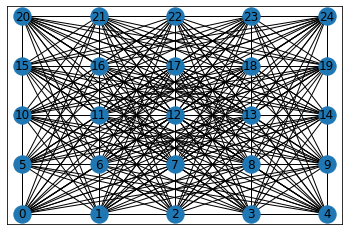

In [142]:
pos0 = [{i : trainloader.dataset[j].x[i,0:2].numpy() 
        for i in range(0,n)} for j in range(0, len(trainloader.dataset))]

G = to_networkx(trainloader.dataset[2], to_undirected=True)

nx.draw_networkx(G, pos=pos0[0], with_labels=True)

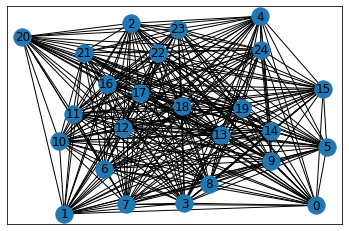

In [143]:
nx.draw_networkx(G, pos=pos0[2], with_labels=True)

In [144]:
 int(10 / (batch/32.0))

20

In [259]:
len(trainloader.dataset)

1500

In [304]:

# We'll use OneCycleLR for fast training:



# Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# With total_epochs=200, batch_per_epoch=2000 it takes ~13h.
total_epochs = 1
batch_per_epoch = 10 # int(1000 / (batch/32.0)) # int(1000*10 / (batch/32.0))
epoch = 0


sched = OneCycleLR(opt, max_lr=init_lr,
                  steps_per_epoch=batch_per_epoch,#len(trainloader),
                  epochs=total_epochs, final_div_factor=1e5)






# Organize the recording of messages over time This is for fitting the forces, and extracting laws:

test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

idxarr=-1*np.ones((11,151), int);

### Train the model:
# Training loop
recorded_models = []

start_time = time.time()
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cpu()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:     # Trainloader has the 1500 samples (pos vel edge index, ...).
            if i >= batch_per_epoch:f
                break
            opt.zero_grad()
            ginput.x = ginput.x.cpu()
            ginput.y = ginput.y.cpu()
            ginput.edge_index = ginput.edge_index.cpu()
            ginput.batch = ginput.batch.cpu()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()
            total_loss += loss.item()
            
            idxarr[epoch,i]= ginput.x[0,4]
            
            i += 1
            print("Epoch: {} ({}%) - {}".format(epoch, 100*i/batch_per_epoch, ginput.x[0,4]), flush=True, end='\r')
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()

    recorded_models.append(ogn.state_dict())





  0%|          | 0/1 [00:00<?, ?it/s]

291.1359352111816 - 324.0


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


In [229]:
unique, counts = np.unique(idxarr, return_counts=True)

In [232]:
len(unique)

962

In [231]:
dict(zip(unique, counts))

{-1: 161,
 2: 2,
 3: 1,
 7: 1,
 8: 5,
 9: 1,
 10: 1,
 11: 1,
 13: 1,
 14: 1,
 18: 1,
 19: 1,
 22: 1,
 23: 2,
 25: 2,
 26: 2,
 27: 2,
 29: 1,
 30: 1,
 32: 4,
 34: 4,
 37: 1,
 38: 1,
 39: 1,
 41: 3,
 45: 2,
 50: 1,
 52: 1,
 54: 2,
 55: 3,
 56: 1,
 57: 2,
 58: 1,
 59: 1,
 60: 1,
 64: 2,
 65: 1,
 66: 1,
 68: 1,
 70: 2,
 72: 2,
 73: 1,
 75: 1,
 81: 2,
 82: 2,
 83: 1,
 86: 3,
 88: 3,
 89: 3,
 90: 1,
 92: 2,
 93: 2,
 94: 2,
 95: 1,
 98: 3,
 100: 2,
 101: 2,
 102: 1,
 103: 1,
 105: 1,
 106: 3,
 107: 1,
 109: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 120: 1,
 123: 1,
 124: 1,
 126: 1,
 128: 1,
 130: 2,
 131: 1,
 132: 1,
 133: 2,
 134: 1,
 135: 2,
 136: 2,
 137: 2,
 138: 1,
 141: 1,
 143: 1,
 145: 1,
 146: 1,
 147: 3,
 148: 5,
 150: 1,
 151: 1,
 152: 1,
 153: 5,
 155: 1,
 156: 2,
 158: 1,
 159: 1,
 161: 1,
 164: 1,
 165: 1,
 166: 1,
 167: 1,
 171: 2,
 172: 2,
 173: 1,
 174: 1,
 175: 2,
 176: 2,
 177: 2,
 178: 1,
 179: 1,
 181: 1,
 182: 3,
 183: 2,
 185: 1,
 186: 2,
 187: 2,
 188: 2,
 191:

# **Analysis**

In [305]:
messages_over_time[0].r

0         4.350513
1         2.912750
2         3.136226
3         1.150927
4         4.802908
            ...   
299395    2.770192
299396    3.424479
299397    1.103457
299398    4.658330
299399    4.883145
Name: r, Length: 600000, dtype: float32

In [307]:
messages_over_time[0]

x1       y1       vx1       vy1      q1   m1        x2       y2  \
0       4.14718  5.17059  0.882740  0.469862  1916.0  1.0  0.586631  7.67048   
1       4.14718  5.17059  0.882740  0.469862  1916.0  1.0  1.254710  5.51371   
2       4.14718  5.17059  0.882740  0.469862  1916.0  1.0  1.615190  3.31993   
3       4.14718  5.17059  0.882740  0.469862  1916.0  1.0  3.955420  6.30543   
4       4.14718  5.17059  0.882740  0.469862  1916.0  1.0  8.356340  7.48379   
...         ...      ...       ...       ...     ...  ...       ...      ...   
299395  2.93416  6.18407 -0.996382  0.084986  1688.0  1.0  1.774520  3.66828   
299396  2.93416  6.18407 -0.996382  0.084986  1688.0  1.0  5.567530  3.99491   
299397  2.93416  6.18407 -0.996382  0.084986  1688.0  1.0  3.948950  5.75069   
299398  2.93416  6.18407 -0.996382  0.084986  1688.0  1.0  5.839520  2.54279   
299399  2.93416  6.18407 -0.996382  0.084986  1688.0  1.0  6.960510  8.94697   

             vx2       vy2  ...       e95        e96       e97        e98  \
0       0.530765 -0.847519  ... -0.240408  25.584837  0.558128  -9.806380   
1       0.474380  0.880320  ... -0.244695  25.597769  0.577238  -9.860218   
2       0.173254 -0.984877  ... -0.250463  25.619286  0.609693  -9.929792   
3      -0.966896 -0.255172  ... -0.261127  25.612341  0.510805  -9.929626   
4      -0.869529 -0.493881  ... -0.270077  25.642363  0.418469 -10.015157   
...          ...       ...  ...       ...        ...       ...        ...   
299395  0.232858 -0.972511  ... -0.207747  22.585924  0.503520  -8.720645   
299396  0.655852  0.754889  ... -0.213535  22.611153  0.432700  -8.795251   
299397  0.868524 -0.495646  ... -0.206152  22.592051  0.436143  -8.722159   
299398  0.678233  0.734847  ... -0.215678  22.622620  0.452099  -8.833313   
299399 -0.600479 -0.799640  ... -0.220772  22.591267  0.322703  -8.742978   

             e99        dx       dy         r  epoch        loss  
0      -7.601650  3.560549 -2.49989  4.350513      0  291.135935  
1      -7.628368  2.892470 -0.34312  2.912750      0  291.135935  
2      -7.669685  2.531990  1.85066  3.136226      0  291.135935  
3      -7.659613  0.191760 -1.13484  1.150927      0  291.135935  
4      -7.683613 -4.209160 -2.31320  4.802908      0  291.135935  
...          ...       ...      ...       ...    ...         ...  
299395 -6.737024  1.159640  2.51579  2.770192      0  291.135935  
299396 -6.755555 -2.633370  2.18916  3.424479      0  291.135935  
299397 -6.722190 -1.014790  0.43338  1.103457      0  291.135935  
299398 -6.776282 -2.905360  3.64128  4.658330      0  291.135935  
299399 -6.722494 -4.026350 -2.76290  4.883145      0  291.135935  

[600000 rows x 117 columns]

In [293]:
messages_over_time[3]['e0']

0         0.000055
1         0.000055
2         0.000055
3         0.000055
4         0.000055
            ...   
299395    0.000055
299396    0.000055
299397    0.000055
299398    0.000055
299399    0.000055
Name: e0, Length: 600000, dtype: float32

In [289]:
messages_over_time[23]['r']

0         1.479646
1         3.514271
2         2.256177
3         4.344344
4         3.660959
            ...   
299395    2.864421
299396    3.146150
299397    1.594727
299398    4.983828
299399    3.883255
Name: r, Length: 600000, dtype: float32

In [240]:
np.array(messages_over_time)

/home/barri/miniconda3/envs/mlam_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([             x1       y1       vx1       vy1      q1   m1        x2        y2  \
0       2.47949  6.00587  0.566939 -0.823760  1595.0  1.0  0.302459  7.788670   
1       2.47949  6.00587  0.566939 -0.823760  1595.0  1.0  2.366820  1.803410   
2       2.47949  6.00587  0.566939 -0.823760  1595.0  1.0  8.480120  2.512830   
3       2.47949  6.00587  0.566939 -0.823760  1595.0  1.0  5.698210  6.203620   
4       2.47949  6.00587  0.566939 -0.823760  1595.0  1.0  7.373220  1.951860   
...         ...      ...       ...       ...     ...  ...       ...       ...   
299395  7.86565  6.65604 -0.739262  0.673418  1756.0  1.0  8.911970  2.767410   
299396  7.86565  6.65604 -0.739262  0.673418  1756.0  1.0  6.375370  1.703560   
299397  7.86565  6.65604 -0.739262  0.673418  1756.0  1.0  7.577130  2.882430   
299398  7.86565  6.65604 -0.739262  0.673418  1756.0  1.0  1.033330  1.601620   
299399  7.86565  6.65604 -0.739262  0.673418  1756.0  1.0  4.195220  0.408126   

             vx2    

NotImplementedError: The current force function is for a spring. You will need to change the force function below to that expected by your simulation.

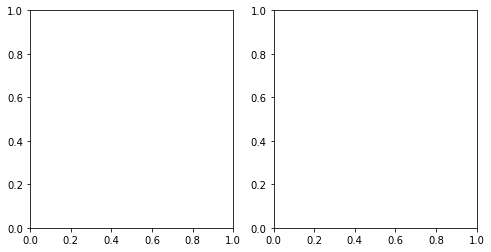

In [297]:

#Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        if sim != 'spring':
            raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")
        #force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        
        -(1-1/r)*(dx,dy)

        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
    
from IPython.display import HTML
HTML(ani.to_jshtml())

# **Scaling**

In [ ]:
# Number of simulations to run (it's fast, don't worry):
ns = 100

# Potential (see below for options)
sim = 'spring'

# Number of nodes
# n = 2

# Dimension
dim = 2

# Number of time steps
nt = 100

# Time step

dt = 0.01

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
# dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

for i in range(0,9):

  n=i+2

  title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
  print('Running on', title)


  # ??? Why nt//2
  from simulate import SimulationDataset
  s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

  # Update this to your own dataset, or regenerate:
  base_str = './'
  data_str = title
  s.simulate(ns)

  # data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
  data = s.data
  accel_data = s.get_acceleration()
  
  onp.save("data_n{0}.npy".format(n), data)
  onp.save("accel_data_n{0}.npy".format(n), accel_data)

  print(i)







Running on spring_n=2_dim=2_nt=100_dt=0.01
0
Running on spring_n=3_dim=2_nt=100_dt=0.01
1
Running on spring_n=4_dim=2_nt=100_dt=0.01
2
Running on spring_n=5_dim=2_nt=100_dt=0.01
3
Running on spring_n=6_dim=2_nt=100_dt=0.01
4
Running on spring_n=7_dim=2_nt=100_dt=0.01
5
Running on spring_n=8_dim=2_nt=100_dt=0.01
6
Running on spring_n=9_dim=2_nt=100_dt=0.01
7
Running on spring_n=10_dim=2_nt=100_dt=0.01
8


In [ ]:
curloss=onp.zeros(9)
execTime=onp.zeros(9)

for ii in range(0,9):

  n=ii+2
  
  data = None
  accel_data = None

  data = onp.load("data_n{0}.npy".format(n))
  accel_data = onp.load("accel_data_n{0}.npy".format(n))

  X = torch.from_numpy(np.concatenate([data[:, i] for i in range(0, data.shape[1], 5)]))
  y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, data.shape[1], 5)]))

  X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


  # L1 regularization

  aggr = 'add'
  hidden = 300

  test = '_l1_'


  #This test applies an explicit bottleneck:

  msg_dim = 100
  n_f = data.shape[3]


  # Custom data loader

  edge_index = get_edge_index(n, sim)


  # Initiate the model

  if test == '_kl_':
      ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
  else:
      ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

  messages_over_time = []
  ogn = ogn.cuda()


  # Test the model
  _q = Data(
      x=X_train[0].cuda(),
      edge_index=edge_index.cuda(),
      y=y_train[0].cuda())
  ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






  ## Set up training

  # Organize into data loader:

  batch = int(64 * (4 / n)**2)
  trainloader = DataLoader(
      [Data(
          Variable(X_train[i]),
          edge_index=edge_index,
          y=Variable(y_train[i])) for i in range(len(y_train))],
      batch_size=batch,
      shuffle=True
  )

  testloader = DataLoader(
      [Data(
          X_test[i],
          edge_index=edge_index,
          y=y_test[i]) for i in range(len(y_test))],
      batch_size=1024,
      shuffle=True
  )

  # We'll use OneCycleLR for fast training:








  # Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
  init_lr = 1e-3

  opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

  # total_epochs = 200
  total_epochs = 5
  epoch = 0


  batch_per_epoch = int(1000*10 / (batch/32.0))

  sched = OneCycleLR(opt, max_lr=init_lr,
                    steps_per_epoch=batch_per_epoch,#len(trainloader),
                    epochs=total_epochs, final_div_factor=1e5)






  # Organize the recording of messages over time This is for fitting the forces, and extracting laws:

  test_idxes = onp.random.randint(0, len(X_test), 1000)

  #Record messages over test dataset here:
  newtestloader = DataLoader(
      [Data(
          X_test[i],
          edge_index=edge_index,
          y=y_test[i]) for i in test_idxes],
      batch_size=len(X_test),
      shuffle=False
  )



  ### Train the model:
  # Training loop
  recorded_models = []

  start_time = time.time()
  for epoch in tqdm(range(epoch, total_epochs)):
      ogn.cuda()
      total_loss = 0.0
      i = 0
      num_items = 0
      while i < batch_per_epoch:
          for ginput in trainloader:
              if i >= batch_per_epoch:
                  break
              opt.zero_grad()
              ginput.x = ginput.x.cuda()
              ginput.y = ginput.y.cuda()
              ginput.edge_index = ginput.edge_index.cuda()
              ginput.batch = ginput.batch.cuda()
              if test in ['_l1_', '_kl_']:
                  loss, reg = new_loss(ogn, ginput, square=False)
                  ((loss + reg)/int(ginput.batch[-1]+1)).backward()
              else:
                  loss = ogn.loss(ginput, square=False)
                  (loss/int(ginput.batch[-1]+1)).backward()
              opt.step()
              sched.step()

              total_loss += loss.item()
              i += 1
              num_items += int(ginput.batch[-1]+1)

      cur_loss = total_loss/num_items
      print(cur_loss)
      cur_msgs = get_messages(ogn)
      cur_msgs['epoch'] = epoch
      cur_msgs['loss'] = cur_loss
      messages_over_time.append(cur_msgs)
      
      ogn.cpu()

      recorded_models.append(ogn.state_dict())
      
  execTime[ii] = time.time() - start_time
  curloss[ii] = cur_loss





 20%|██        | 1/5 [00:19<01:19, 19.95s/it]

4.600963364413056


 40%|████      | 2/5 [00:39<00:59, 19.95s/it]

1.877331903130701


 60%|██████    | 3/5 [01:00<00:40, 20.12s/it]

0.6428045418915289


 80%|████████  | 4/5 [01:20<00:20, 20.15s/it]

0.26223884994393365


  0%|          | 0/5 [00:00<?, ?it/s]

0.09141844771642214


 20%|██        | 1/5 [00:28<01:52, 28.25s/it]

7.307294647658556


 40%|████      | 2/5 [00:56<01:25, 28.34s/it]

2.6218347988990285


 60%|██████    | 3/5 [01:25<00:56, 28.33s/it]

1.0893115162791656


 80%|████████  | 4/5 [01:53<00:28, 28.34s/it]

0.453657749578787


  0%|          | 0/5 [00:00<?, ?it/s]

0.11213621846434205


 20%|██        | 1/5 [00:40<02:42, 40.64s/it]

12.672796658651276


 40%|████      | 2/5 [01:21<02:02, 40.69s/it]

4.449980289348198


 60%|██████    | 3/5 [02:01<01:21, 40.61s/it]

1.776701557924336


 80%|████████  | 4/5 [02:42<00:40, 40.64s/it]

0.7286214214928346


  0%|          | 0/5 [00:00<?, ?it/s]

0.12361844129791358
16.251903555703446


 20%|██        | 1/5 [00:57<03:50, 57.63s/it]

5.240659064199258


 40%|████      | 2/5 [01:54<02:52, 57.54s/it]

2.2839332781877184


 60%|██████    | 3/5 [02:52<01:55, 57.60s/it]

0.9497137830581986


 80%|████████  | 4/5 [03:50<00:57, 57.57s/it]

0.1588989896591905


  0%|          | 0/5 [00:00<?, ?it/s]

17.224450823080403


 20%|██        | 1/5 [01:16<05:05, 76.37s/it]

5.3063084395840585


 40%|████      | 2/5 [02:32<03:48, 76.29s/it]

2.52274660278457


 60%|██████    | 3/5 [03:48<02:32, 76.27s/it]

1.0530189221042432


 80%|████████  | 4/5 [05:04<01:16, 76.27s/it]

0.1720548631158216


  0%|          | 0/5 [00:00<?, ?it/s]

28.807488605300314


 20%|██        | 1/5 [01:41<06:45, 101.34s/it]

8.838417829123793


 40%|████      | 2/5 [03:22<05:03, 101.33s/it]

4.191259093214997


 60%|██████    | 3/5 [05:04<03:22, 101.39s/it]

1.788855936765905


 80%|████████  | 4/5 [06:45<01:41, 101.39s/it]

0.2935164096377786


  0%|          | 0/5 [00:00<?, ?it/s]

30.42405432396168


 20%|██        | 1/5 [02:03<08:12, 123.10s/it]

9.306152364918193


 40%|████      | 2/5 [04:06<06:09, 123.18s/it]

4.636468843391056


 60%|██████    | 3/5 [06:09<04:06, 123.10s/it]

1.9265303448242732


 80%|████████  | 4/5 [08:12<02:03, 123.20s/it]

0.31845872095899114


  0%|          | 0/5 [00:00<?, ?it/s]

42.08324425117463


 20%|██        | 1/5 [02:40<10:41, 160.35s/it]

14.066581405491076


 40%|████      | 2/5 [05:20<08:00, 160.23s/it]

6.962661142905068


 60%|██████    | 3/5 [08:01<05:20, 160.49s/it]

2.957296612049027


 80%|████████  | 4/5 [10:44<02:41, 161.16s/it]

0.5120104143452031


  0%|          | 0/5 [00:00<?, ?it/s]

53.06150375523567


 20%|██        | 1/5 [03:11<12:46, 191.70s/it]

17.572723817789555


 40%|████      | 2/5 [06:23<09:35, 191.79s/it]

9.052033546638489


 60%|██████    | 3/5 [09:36<06:24, 192.16s/it]

3.867786881995201


 80%|████████  | 4/5 [12:49<03:12, 192.38s/it]

0.6967016122542322


100%|██████████| 5/5 [16:03<00:00, 192.69s/it]


In [ ]:
nParts=[2,3,4,5,6,7,8,9,10]

In [ ]:
onp.save("trainingTimeVSnParticles.npy", execTime)
onp.save("lossVSnParticles.ny", curloss)


Text(0, 0.5, 'Loss')

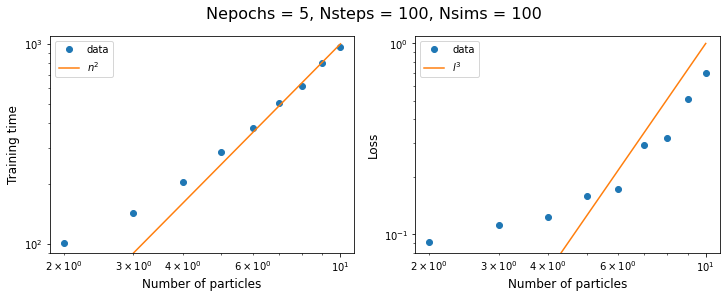

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

fig.suptitle('Nepochs = 5, Nsteps = 100, Nsims = 100', fontsize=16)

ax1.plot(nParts, execTime, 'o', label='data')
ax1.plot(nParts, 10*onp.square(nParts), '-', label='$n^2$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(90,1100)
ax1.legend()
# ax1.grid(True)
ax1.set_xlabel('Number of particles', fontsize=12)
ax1.set_ylabel('Training time', fontsize=12)
#ax1.axes.get_xaxis().set_visible(False)

ax2.plot(nParts, curloss, 'o', label='data')
ax2.plot(nParts, 0.001*onp.power(nParts,3), '-', label='$l^3$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(0.08,1.1)
ax2.legend()
ax2.set_xlabel('Number of particles', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)

In [ ]:
fig.savefig('trainingTime-LossVSnParticles.png')